In [11]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import lightgbm as lgb
from lightgbm import LGBMClassifier
#from bayes_opt import BayesianOptimization
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import cross_validation

In [12]:
# Function for Measure Performance# 
from  sklearn  import  metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True, show_roc_auc = True):
    y_pred = clf.predict(X)
    y_predprob = clf.predict_proba(X)[:,1]
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred))),"\n"

    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y,y_pred)),"\n"
        
    if show_confusion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y,y_pred)),"\n"  
        
    if show_roc_auc:
        print("ROC AUC Score")
        print(metrics.roc_auc_score(y,y_predprob)),"\n"

In [13]:
#Data Preparation for LightGBM
import os
application_train = pd.read_csv('train_modified.csv')

# use LabelEncoder to convert categorical features to int type before construct Dataset
from sklearn.preprocessing import LabelEncoder
def label_encoder(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    # Label encode categoricals
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    return input_df, categorical_feats.tolist(), encoder_dict
application_train, categorical_feats, encoder_dict = label_encoder(application_train)
X = application_train.drop('TARGET', axis=1)
y = application_train.TARGET

# Prepare dataset 
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=test_size, random_state=seed)

In [17]:
# Grid Search
print('Start training...')
estimator = lgb.LGBMClassifier(objective = 'binary', learning_rate = 0.05, n_estimators = 100, random_state=0)

param_grid = {
    'num_leaves': [38,40,42], #[35,40,45]做完是40
    'feature_fraction': [0.4],#做過[0.2,0.3,0.4,0.5]出來是0.4
    #'bagging_fraction': [0.6,0.7,0.8],
    'max_depth':[4,6,8],
    'max_bin':[10,15,20],
    'lambda_l1':[0.1,0.2,0.3],#V4開始做lambda_l1
    #'lambda_l2':[0.08,0.09,0.1],
    'min_split_gain':[0.05,0.06,0.07],#做過[0.04,0.05,0.06]出來0.06
    'min_child_weight':[7]
}

%time LGBM_grid = GridSearchCV(estimator, param_grid)

Start training...
CPU times: user 719 µs, sys: 451 µs, total: 1.17 ms
Wall time: 526 µs


In [18]:
LGBM_grid.fit(X_train, y_train)
print('Best parameters found by grid search are:', LGBM_grid.best_params_)

Best parameters found by grid search are: {'feature_fraction': 0.4, 'lambda_l1': 0.3, 'max_bin': 20, 'max_depth': 8, 'min_child_weight': 7, 'min_split_gain': 0.05, 'num_leaves': 40}


In [19]:
# Final Model
evals_result = {} 
print('Start predicting...')
LGBM_grid_final = lgb.LGBMClassifier(objective = 'binary',
                                      learning_rate = 0.05, 
                                     n_estimators = 100, 
                                     random_state=0,
                              num_leaves = LGBM_grid.best_params_['num_leaves'],
                                feature_fraction = LGBM_grid.best_params_['feature_fraction'], 
                              #bagging_fraction = LGBM_grid.best_params_['bagging_fraction'],
                             max_depth = LGBM_grid.best_params_['max_depth'],
                              max_bin = LGBM_grid.best_params_['max_bin'],
                              lambda_l1 = LGBM_grid.best_params_['lambda_l1'],
                              #lambda_l2 = LGBM_grid.best_params_['lambda_l2'],
                            min_split_gain = LGBM_grid.best_params_['min_split_gain'],
                            min_child_weight = LGBM_grid.best_params_['min_child_weight'])
%time LGBM_grid_final_fit = LGBM_grid_final.fit(X_train, y_train)
print('Predicting is over')

Start predicting...
CPU times: user 7.33 s, sys: 1.68 s, total: 9.01 s
Wall time: 4.07 s
Predicting is over


Accuracy:0.919
Classification report
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96     84807
        1.0       0.50      0.00      0.00      7447

avg / total       0.89      0.92      0.88     92254

Confusion matrix
[[84804     3]
 [ 7444     3]]
ROC AUC Score
0.7206871646091437
Feature importances: [336, 278, 282, 139, 256, 293, 165, 110, 546, 148, 64, 105, 48, 82, 262, 90, 62, 0, 40, 84, 71, 77, 59, 80, 52, 32, 12, 1, 27, 20, 11, 19, 18, 20, 11]
Plot feature importances...


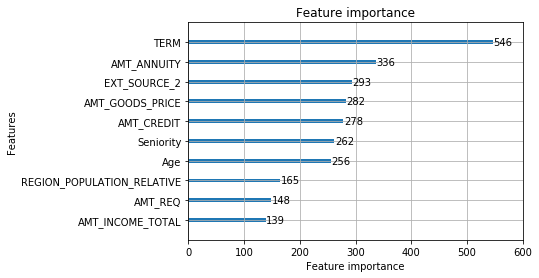

In [20]:
LGBM_grid_measure = measure_performance(X = X_test, y = y_test, clf = LGBM_grid_final, show_classification_report=True, show_confusion_matrix=True)

# feature importances
print('Feature importances:', list(LGBM_grid_final.feature_importances_))

# visualization
print('Plot feature importances...')
ax = lgb.plot_importance(LGBM_grid_final_fit, max_num_features=10)
plt.show()

In [21]:
# Submission file
application_test = pd.read_csv('test_modified.csv')
test_df = label_encoder(application_test)[0]

#Bayes Optimization
'''
out_bayes = pd.DataFrame({"SK_ID_CURR":test_df["SK_ID_CURR"], "TARGET":LGBM_bayes.predict_proba(test_df)[:,1]})
out_bayes.to_csv("submissions_toy_bayes.csv", index=False)
'''
#Grid Search
out_grid = pd.DataFrame({"SK_ID_CURR":test_df["SK_ID_CURR"], "TARGET":LGBM_grid.predict_proba(test_df)[:,1]})
out_grid.to_csv("submissions_HomeCredit_grid_V6.csv", index=False)

In [22]:
see= pd.read_csv('submissions_HomeCredit_grid_V6.csv')
see

,SK_ID_CURR,TARGET
0,100001,0.029033
1,100005,0.113194
2,100013,0.028415
3,100028,0.052622
4,100038,0.121605
5,100042,0.039238
6,100057,0.053034
7,100065,0.091093
8,100066,0.043608
9,100067,0.037008
